In [1]:
import numpy as np
import sys
import h5py
import tables
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools

import sys
from pathlib import Path

# import psana as ps

import ana_fun as ana

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

In [3]:
from importlib import reload
reload(ana)

<module 'ana_fun' from '/cds/home/e/espov/lcls_software_tools/example_notebooks/ana_fun.py'>

# Preamble

Because the the intensity and I0 are not independant (in fact they are highly correlated), the proper handling of the error bar calculation for the I/I0 ratio requires the use of the covariance. 

Combinations of variances and covariances across different datasets (runs) is not straigh-forward and can be done using the helper functions in ana_fun.

One the combination is done, the error calculation for the ratio is also provided. Refer to the function description in ana_fun.py for more details about the calculation and references.

In [4]:
runs = [0,0] # dummy example combining the example run twice
loff = True

path = Path('/cds/group/psdm/sw/tools/smalldata_tools/example_notebooks/binned/')

tts = []
tts_off = []
for run in runs:
    fname = path / f'r{run}_lon.h5'
    tt = tables.File(fname).root
    tts.append(tt)
    
    if loff:
        fname = path / f'r{run}_loff.h5'
        tt = tables.File(fname).root
        tts_off.append(tt)

# variables of interest
scanvar = 'scanvar'
intensity = 'intensity'
i0 = 'i0'
covariance = 'covariance' # assume cov between intensity and i0

# check that the scanvar axis matches for all runs
for (t1,t2), (r1,r2) in zip(itertools.product(tts,tts), itertools.product(runs, runs)):
    eq = np.array_equal(t1['scanvar'], t2['scanvar'])
    if eq is False:
        print(f'Problem with scanvar in run {r1} and {r2}')

scanvar = tts[0][scanvar]

# Make arrays and combine them

In [5]:
# lon (or single)
counts = np.asarray([tt['count'] for tt in tts])
intensity_mean = np.asarray([tt[f'{intensity}_mean'] for tt in tts])
intensity_var = np.asarray([tt[f'{intensity}_var'] for tt in tts])
i0_mean = np.asarray([tt[f'{i0}_mean'] for tt in tts])
i0_var = np.asarray([tt[f'{i0}_var'] for tt in tts])
covs = np.asarray([tt[covariance][:,0,1] for tt in tts]) # get only off-diag element

# loff
if loff:
    counts_off = np.asarray([tt['count'] for tt in tts_off])
    intensity_mean_off = np.asarray([tt[f'{intensity}_mean'] for tt in tts_off])
    intensity_var_off = np.asarray([tt[f'{intensity}_var'] for tt in tts_off])
    i0_mean_off = np.asarray([tt[f'{i0}_mean'] for tt in tts_off])
    i0_var_off = np.asarray([tt[f'{i0}_var'] for tt in tts_off])
    cov_off = np.asarray([tt[covariance][:,0,1] for tt in tts_off]) # get only off-diag element

## (i) Combine covariance

In [6]:
cov = ana.combine_covariance(intensity_mean, i0_mean, covs, counts)

cov_off = ana.combine_covariance(intensity_mean_off, i0_mean_off, cov_off, counts_off)

## (ii) Combine intensities variance and mean

In [7]:
intensity_var = ana.combine_variance(intensity_mean, intensity_var, counts)
intensity = ana.combine_mean(intensity_mean, counts)

intensity_var_off = ana.combine_variance(intensity_mean_off, intensity_var_off, counts_off)
intensity_off = ana.combine_mean(intensity_mean_off, counts_off)

## (iii) Combine I0s variance and mean

In [8]:
i0_var = ana.combine_variance(i0_mean, i0_var, counts)
i0 = ana.combine_mean(i0_mean, counts)

i0_var_off = ana.combine_variance(i0_mean_off, i0_var_off, counts_off)
i0_off = ana.combine_mean(i0_mean_off, counts_off)

## (iv) Add counts

In [9]:
counts = counts.sum(axis=0)

counts_off = counts_off.sum(axis=0)

# Visualization

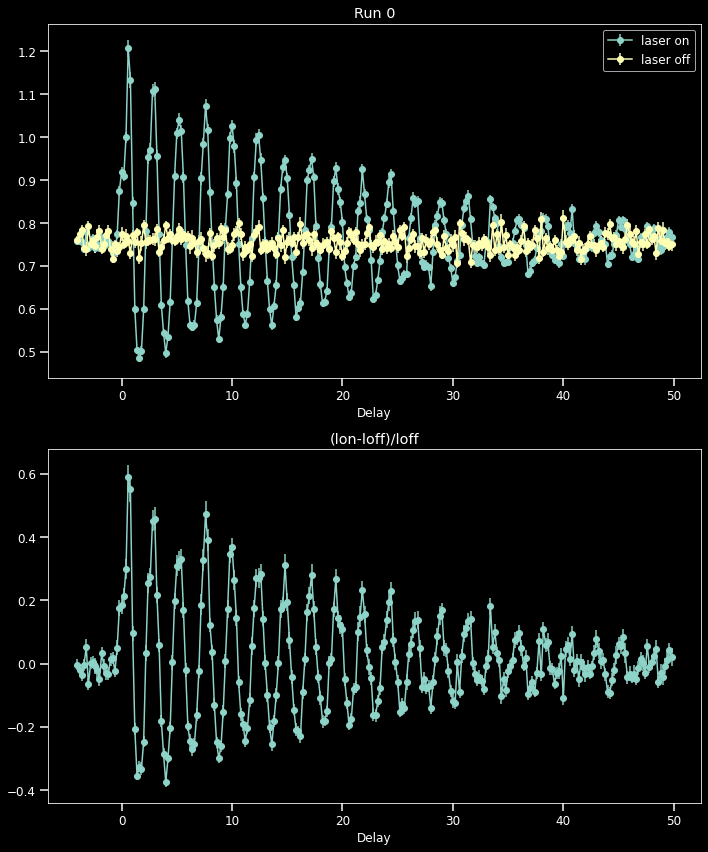

In [10]:
x = scanvar
y = intensity/i0
err = ana.variance_of_ratio(intensity, i0, intensity_var, i0_var, cov)
err = np.sqrt(np.abs(err))/np.sqrt(counts)

xloff = scanvar
yloff = intensity_off/i0_off
errloff = ana.variance_of_ratio(intensity_off, i0_off, intensity_var_off, i0_var_off, cov_off)
errloff = np.sqrt(np.abs(errloff))/np.sqrt(counts_off)

fig, ax = plt.subplots(nrows=2, figsize=(10,12))
ax[0].set_title('Run {}'.format(run))
ax[0].errorbar(x, y, yerr=err, fmt='-o', label='laser on')
ax[0].errorbar(xloff, yloff, yerr=errloff, fmt='-o', label='laser off')
ax[0].legend()
ax[0].set_xlabel('Delay')

ax[1].set_title('(lon-loff)/loff')
err_ = np.sqrt( (1/yloff)**2*err**2 + (y/yloff**2)**2*errloff**2 ) # error propagation
ax[1].errorbar(x, (y-yloff)/yloff, yerr=err_, fmt='-o')
ax[1].set_xlabel('Delay')
# ax[1].set_xlim(-2,10)
plt.tight_layout()
plt.show()

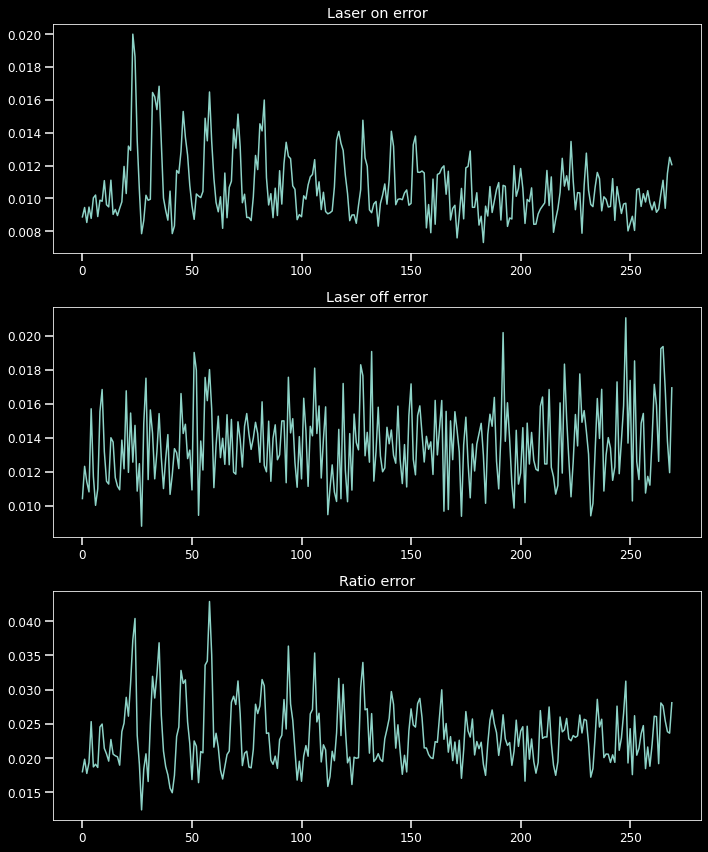

In [11]:
""" A view on the errorbars """
fig, ax = plt.subplots(nrows=3, figsize=(10,12))
ax[0].set_title('Laser on error')
ax[0].plot(err)
ax[1].set_title('Laser off error')
ax[1].plot(errloff)
ax[2].set_title('Ratio error')
ax[2].plot(err_)
plt.tight_layout()
plt.show()

# Test with covariance (DEV)

In [12]:
def cov(v1, v2):
    n = v1.size
    m1 = v1.mean()
    m2 = v2.mean()
    d = np.stack((v1,v2), axis=1)
    d -= np.average(d, axis=0)
    c = d.T.dot(d)
    return c/(n-1)

In [13]:
# dataset 1
n1 = 100
a1 = np.random.normal(loc=1, size=n1)
b1 = np.random.lognormal(size=n1)

# dataset 2
n2 = 160
a2 = np.random.normal(size=n2)
b2 = np.random.lognormal(size=n2)

# combined dataset
n = n1 + n2
a = np.r_[a1,a2]
b = np.r_[b1,b2]

# covariances
cov1 = cov(a1,b1)
cov2 = cov(a2,b2)

print(cov(a,b))

[[1.54929799 0.11579374]
 [0.11579374 4.03432606]]


In [14]:
# Combine covar
ma1 = a1.mean()
mb1 = b1.mean()
ma2 = a2.mean()
mb2 = b2.mean()

# ma = (n1*ma1 + n2*ma2)/n
# mb = (n1*mb1 + n2*mb2)/n

# c1 = cov1*(n1-1) + cov2*(n2-1)
# c2 = n1 * (ma*mb - ma*mb1 - mb*ma1 + ma1*mb1) + n2 * (ma*mb - ma*mb2 - mb*ma2 + ma2*mb2)
# c = (c1+c2)/(n-1)
# print(c)
# print(c1)
# print(c2)

In [15]:
covs = np.asarray([cov1, cov2])
means_a = np.asarray([ma1, ma2])
means_b = np.asarray([mb1, mb2])
k = np.asarray([n1,n2])
means_all_a = np.sum(k*means_a)/k.sum()
means_all_b = np.sum(k*means_b)/k.sum()

c1 = np.sum(((k-1)*covs.T).T, axis=0) # k multiplication is done with the last index
c2 = np.sum(k*(means_all_a*means_all_b - means_all_b*means_a - means_all_a*means_b + means_a*means_b), axis=0)
c = c1+c2
print(c/(k.sum()-1))

[[1.24198794 0.11579374]
 [0.11579374 4.04974611]]


In [16]:
c = ana.combine_covariance(means_a, means_b, covs, k)
print(c)

0.1157937426123942


In [17]:
# # Combine covar
# ma1 = a1.mean()
# mb1 = ma1
# ma2 = a2.mean()
# mb2 = ma2

# ma = (n1*ma1 + n2*ma2)/n
# mb = (n1*mb1 + n2*mb2)/n

# c1 = cov1*(n1-1) + cov2*(n2-1)
# c2 = n1 * (ma*mb - ma*mb1 - mb*ma1 + ma1*mb1) + n2 * (ma*mb - ma*mb2 - mb*ma2 + ma2*mb2)
# c = (c1+c2)/(n-1)
# print(c)